# Binary Classification Text Classification with BERT

In [1]:
import os
import json
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.pyplot import figure

%matplotlib inline

RANDOM_SEED = 123

pl.seed_everything(RANDOM_SEED)
pd.options.display.max_colwidth = 100

Global seed set to 123


In [2]:
# Require to change: 
parent_dir = '~/Conv_BERT/task-specific-datasets/banking_data/'
train_path = parent_dir + 'train.csv'
test_path = parent_dir + 'test.csv'
logging_path = 'lightning_logs_temp'
checkpoint_path = 'checkpoints_temp'
BERT_MODEL_NAME = 'bert-base-cased'
MAX_TOKEN_COUNT = 300
N_EPOCHS = 2
BATCH_SIZE = 6
dialog_data_file = '/h/elau/Conv_BERT/multilabel_class_part1/outputMul2.2.json'
valid_list_file = '/h/elau/Conv_BERT/multilabel_class_part1/MultiWOZ_2.1/valListFile.txt'
test_list_file = '/h/elau/Conv_BERT/multilabel_class_part1/MultiWOZ_2.1/testListFile.txt'

## Data Processing

In [3]:
def load_json(data_file):
    if os.path.isfile(data_file):
        with open(data_file, 'r') as read_file:
            data = json.load(read_file)
            return data

def load_list_file(list_file):
    with open(list_file, 'r') as read_file:
        dialog_id_list = read_file.readlines()
        dialog_id_list = [l.strip('\n') for l in dialog_id_list]
        return dialog_id_list

In [4]:
dialog_data = load_json(dialog_data_file)
dialog_id_list = list(set(dialog_data.keys()))

valid_id_list = list(set(load_list_file(valid_list_file)))
test_id_list = load_list_file(test_list_file)
train_id_list = [did for did in dialog_id_list if did not in (valid_id_list + test_id_list)]

print('# of train dialogs:', len(train_id_list))
print('# of valid dialogs:', len(valid_id_list))
print('# of test dialogs :', len(test_id_list))
assert(len(dialog_id_list) == len(train_id_list) + len(valid_id_list) + len(test_id_list))

train_data = [v for k, v in dialog_data.items() if k in train_id_list]
valid_data = [v for k, v in dialog_data.items() if k in valid_id_list]
test_data = [v for k, v in dialog_data.items() if k in test_id_list]
assert(len(train_data) == len(train_id_list))
assert(len(valid_data) == len(valid_id_list))
assert(len(test_data) == len(test_id_list))

# of train dialogs: 8437
# of valid dialogs: 1000
# of test dialogs : 1000


In [5]:
data = train_data + valid_data + test_data
print(len(data))
print(train_data[0])

10437
{'goal': {'attraction': {}, 'hospital': {}, 'hotel': {'book': {'day': 'saturday', 'invalid': False, 'people': '6', 'pre_invalid': True, 'stay': '1'}, 'fail_book': {'stay': '2'}, 'fail_info': {}, 'info': {'internet': 'no', 'stars': '3', 'type': 'guesthouse'}}, 'message': ['You are looking for information in Cambridge', "You are looking for a <span class='emphasis'>place to dine</span>. The restaurant should serve <span class='emphasis'>indian</span> food and should be in the <span class='emphasis'>expensive</span> price range", "The restaurant should be in the <span class='emphasis'>centre</span>", "Once you find the <span class='emphasis'>restaurant</span> you want to book a table for <span class='emphasis'>6 people</span> at <span class='emphasis'>19:30</span> on <span class='emphasis'>saturday</span>", "Make sure you get the <span class='emphasis'>reference number</span>", "You are also looking for a <span class='emphasis'>hotel</span>. The hotel should have <span class='emphas

In [6]:
questions = []
answers = []
overall_intents = []
domains_v1 = []
general_intents = []
original_data = []
original_user_data = [] 

def get_dst_diff(prev_d, crnt_d):
    diff = {}
    for ((k1, v1), (k2, v2)) in zip(prev_d.items(), crnt_d.items()):
        if v1 != v2: # updated
            diff[k2] = v2
    return diff

def analyze_dialog(d, print_dialog=True):
    domains = []
    ignore_keys_in_goal = ['eod', 'messageLen', 'message'] # eod (probably) means the user archieved the goal. 
    for dom_k, dom_v  in d['goal'].items():
        if dom_v and dom_k not in ignore_keys_in_goal: # check whether contains some goal entities
            domains.append(dom_k)
#     print('{} domain(s): {}'.format(len(domains), domains))

    prev_user = ''
    if print_dialog:
        prev_d = None
        for i, t in enumerate(d['log']):
            spk = 'Usr' if i % 2 == 0 else 'Sys' # Turn 0 is always a user's turn in this corpus.
            if spk == 'Sys':
                if prev_d is None:
                    prev_d = t['metadata']
                else:
                    crnt_d = t['metadata']
                    dst_diff = get_dst_diff(prev_d, crnt_d)
                    user_intent = t['dialog_act']
                    if user_intent != {}:
                        get_intent = user_intent
                        get_intent = list(get_intent.keys())[0]
                        
                    
                    curr_intents = ''
                    for domain, rest in dst_diff.items():
#                      print(dst_diff)
                      for intent in rest:
                        for key, value in rest[intent].items():
                          if value != 'not mentioned' and value != '' and value != []:
#                             print(value)
#                             print('Updated DST:', dst_diff)
                            # print("CURRENT INTENTS", intent + " " + key)
                            curr_intents = curr_intents + domain + "-" + intent + "-" + key + " "
                    if dst_diff != {} and curr_intents != '' and user_intent != {}:
#                         print("**************************")
#                         print('Updated DST:', t)
                        questions.append(u)
                        answers.append(t['text'])
                        domains_v1.append(list(dst_diff.keys()))
                        temp = []
#                         for x in get_intent:
#                             temp.append(x.split('-')[1])
                        general_intents.append(get_intent.split('-')[1])
                        overall_intents.append(curr_intents)
                        original_data.append(t)
                        original_user_data.append(prev_data)
                        break
#                     
                    prev_d = crnt_d
            u = t['text']
#             user_intent = t['dialog_act']
            prev_data = t
            # print('{}: {}'.format(spk, u))

for d in data:
#     print('-' * 50)
    analyze_dialog(d, True)

In [7]:
print("SUMMARY")
print("DOMAIN")
print(domains_v1[1])
print("OVERALL INTENTS")
print(overall_intents[1])
print("QUESTIONS")
print(questions[1])
print("ANSWERS")
print(answers[1])
print("GENERIC INTENT")
print(general_intents[1])
# print("ORIGINAL USER")
# print(original_user_data[1])
# print("ORIGINAL SYSTEM")
# print(original_data[1])

print("CHECKING IF LENGTH IS THE SAME")
print(len(domains_v1) == len(overall_intents) == len(questions) == len(answers))
print(len(questions))

SUMMARY
DOMAIN
['restaurant']
OVERALL INTENTS
restaurant-semi-area restaurant-semi-food 
QUESTIONS
I'd like to have some Chinese food.
ANSWERS
That narrows down the restaurant choices to 10. Is there a price range you would like to stay in?
GENERIC INTENT
Inform
CHECKING IF LENGTH IS THE SAME
True
9731


In [8]:
df_general = pd.read_csv('/h/elau/Conv_BERT/botframework-smalltalk/smalltalkkb.tsv', sep='\t')
df_general_questions = list(df_general['Question'])
answers = answers + df_general_questions
df_general_intents = []
for i in range(len(df_general_questions)):
    df_general_intents.append('general')
print(len(df_general_intents))
general_intents = general_intents + df_general_intents
print(len(general_intents))
print(len(answers))

1473
11204
11204


In [9]:
thisdict = {
    "welcome": "remove",
    "thank": "remove",
    "greet": "remove",
    "OfferBooked": 'request',
    "OfferBook": 'request',
    "Recommend": 'request',
    "Inform": 'request',
    "Book": 'request',
    "Request": 'request',
    'NoBook': 'request',
    'bye': 'remove',
    'NoOffer': 'request',
    'Select': 'remove', 
    'reqmore': 'remove',
    'general': 'general'
}

In [10]:
# Get the unique values in the intents
unique_intents = list(set(general_intents)) 
print(len(unique_intents))
print(unique_intents)

from collections import Counter
flattened = [val for sublist in domains_v1 for val in sublist]
print(Counter(flattened))

14
['Request', 'Select', 'reqmore', 'welcome', 'OfferBook', 'Book', 'NoOffer', 'NoBook', 'Inform', 'bye', 'greet', 'OfferBooked', 'general', 'Recommend']
Counter({'restaurant': 3067, 'hotel': 2502, 'train': 2376, 'attraction': 1376, 'taxi': 436, 'hospital': 44, 'bus': 3})


In [11]:
mapping_intents = thisdict.values()
mapping_intents = list(set(mapping_intents))
generic_intents = mapping_intents
print(generic_intents)

['general', 'request', 'remove']


In [12]:
# Converting the intents into categorical columns 
def preprocessing(mapping_intents):
    cat_overall_intents = []

    for i in range(len(general_intents)):
        cat_curr_intent = []

        for ele in mapping_intents:
    #         print(general_intents[i])
            if thisdict.get(general_intents[i]) == ele:
                cat_curr_intent.append(1)
            else: 
                cat_curr_intent.append(0)
        cat_overall_intents.append(cat_curr_intent)
        
    d1 = {'cat_overall_intents': cat_overall_intents}
    df2 = pd.DataFrame(d1)
    df3 = pd.DataFrame(df2['cat_overall_intents'].to_list(), columns=generic_intents)
    return df3

In [13]:
df3 = preprocessing(mapping_intents)
df3

,general,request,remove
0,0,1,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,1,0
...,...,...,...
11199,1,0,0
11200,1,0,0
11201,1,0,0
11202,1,0,0


### Dataset 2

In [14]:
df = pd.DataFrame(
    {'comment_text': answers
    })
df = pd.concat([df, df3], axis=1)
df_request = df[df['request'] == 1].drop(['general', 'remove'], 1)
df_general = df[df['general'] == 1].drop(['remove', 'request'], 1)
df_request = df_request.sample(n=len(df_general), random_state=1)

In [15]:
df = pd.concat([df_general, df_request])
df = df.sample(frac=1).reset_index(drop=True)
df['general'] = df['general'].fillna(0)
df['request'] = df['request'].fillna(0)
df

,comment_text,general,request
0,wanna hug,1.0,0.0
1,Yes I have one Spanish restaurant matching your price range and criteria. Would you like their n...,0.0,1.0
2,Okay. Can you give me a time that you'd prefer to leave after or arrive by?,0.0,1.0
3,you are very helpful,1.0,0.0
4,I have 13 in the centre area of town. The emmanuel college is nice and it is free.,0.0,1.0
...,...,...,...
2941,glad to meet you,1.0,0.0
2942,"The Riverside Brasserie serves modern european cuisine in the Centre area of town, it is moderat...",0.0,1.0
2943,Yes I have the Curry Garden at 106 Regent Street City Centre. Would you like their telephone num...,0.0,1.0
2944,how is your day going,1.0,0.0


In [16]:
df.head()

,comment_text,general,request
0,wanna hug,1.0,0.0
1,Yes I have one Spanish restaurant matching your price range and criteria. Would you like their n...,0.0,1.0
2,Okay. Can you give me a time that you'd prefer to leave after or arrive by?,0.0,1.0
3,you are very helpful,1.0,0.0
4,I have 13 in the centre area of town. The emmanuel college is nice and it is free.,0.0,1.0


In [17]:
train_df, val_df = train_test_split(df, test_size=0.05)
train_df.shape, val_df.shape 

((2798, 3), (148, 3))

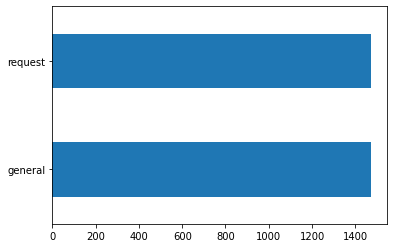

In [18]:
# Distribution
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

### Tokenization


In [19]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [20]:
sample_row = train_df.iloc[15]
sample_comment = sample_row.comment_text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

you are good

{'general': 1.0, 'request': 0.0}


In [21]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=300,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

In [22]:
print(encoding["input_ids"].shape, encoding["attention_mask"].shape)

torch.Size([1, 300]) torch.Size([1, 300])


In [23]:
print(encoding["input_ids"].squeeze()[:50])
print(encoding["attention_mask"].squeeze()[:50])

tensor([ 101, 1128, 1132, 1363,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [24]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'you', 'are', 'good', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


67


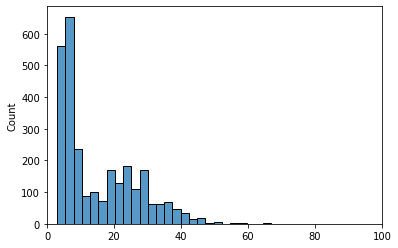

In [25]:
# Distribution of the tokenized sentences
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

sns.histplot(token_counts)
print(max(token_counts))
plt.xlim([0, 100]);

### Dataset

In [26]:
class Generic_Dataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [27]:
train_dataset = Generic_Dataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [28]:
print(sample_item["comment_text"])
print(sample_item["labels"])
print(sample_item["input_ids"].shape)

haha very funny
tensor([1., 0.])
torch.Size([300])


In [29]:
class Generic_DataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = Generic_Dataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = Generic_Dataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [30]:
data_module = Generic_DataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

Binary Cross Entropy is used to measure the error for each label since we are doing binary classification for each label.

In [31]:
class Tagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
        for out_labels in output["labels"].detach().cpu():
            labels.append(out_labels)
        for out_predictions in output["predictions"].detach().cpu():
            predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
        class_roc_auc = auroc(predictions[:, i], labels[:, i])
        self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
  )

In [32]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(186, 932)

In [33]:
# Create an instance of the model
model = Tagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

## Training

In [34]:
!rm -rf logging_path/
!rm -rf checkpoint_path/

%load_ext tensorboard
%tensorboard --logdir ./lightning_logs_banking_77

Reusing TensorBoard on port 6007 (pid 32149), started 0:10:06 ago. (Use '!kill 32149' to kill it.)

In [35]:
checkpoint_callback = ModelCheckpoint(
  dirpath=checkpoint_path,
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory checkpoints_temp exists and is not empty.
  warnings.warn(*args, **kwargs)


In [36]:
logger = TensorBoardLogger(logging_path, name="classification")

In [37]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [38]:
# Training
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [39]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 1.5 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.247   Total estimated model params size (MB)
/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 466: val_loss reached 0.00224 (best 0.00224), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/generalClassification/checkpoints_temp/best-checkpoint-v2.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 933: val_loss reached 0.00143 (best 0.00143), saving model to "/ssd003/home/elau/Conv_BERT/ConversationalAI/intentIdentification/generalClassification/checkpoints_temp/best-checkpoint-v2.ckpt" as top 1


1

In [40]:
# Check validation loss
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ssd003/home/elau/Conv_BERT/BERT_MLM_env/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.0014333755243569613}
--------------------------------------------------------------------------------


[{'test_loss': 0.0014333755243569613}]

## Predictions

In [41]:
trained_model = Tagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()